In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import cv2

---

**Algorithm 3**

In [2]:
def rgb_to_hsi(img):
    
    zmax = 255 # max value
    # values in [0,1]
    R = np.divide(img[:,:,0],zmax,dtype=np.float)
    G = np.divide(img[:,:,1],zmax,dtype=np.float)
    B = np.divide(img[:,:,2],zmax,dtype=np.float)

    # Hue, when R=G=B -> H=90
    a = (0.5)*np.add(np.subtract(R,G), np.subtract(R,B)) # (1/2)*[(R-G)+(R-B)]
    b = np.sqrt(np.add(np.power(np.subtract(R,G), 2) , np.multiply(np.subtract(R,B),np.subtract(G,B))))
    tetha = np.arccos( np.divide(a, b, out=np.zeros_like(a), where=b!=0) ) # when b = 0, division returns 0, so then tetha = 90
    H = (180/math.pi)*tetha # convert rad to degree
    H[B>G]=360-H[B>G]

    # saturation = 1 - 3*[min(R,G,B)]/(R+G+B), when R=G=B -> S=0
    a = 3*np.minimum(np.minimum(R,G),B) # 3*min(R,G,B)
    b = np.add(np.add(R,G),B) # (R+G+B)
    S = np.subtract(1, np.divide(a,b,out=np.ones_like(a),where=b!=0))

    # intensity = (1/3)*[R+G+B]
    I = (1/3)*np.add(np.add(R,G),B)

    return np.dstack((H, zmax*S, np.round(zmax*I))), I # values between [0,360], [0,255] e [0,255]

In [3]:
def f1(I,S): # I(1-S)
    return np.multiply(I, np.subtract(1,S))
    
def f2(I,S,H): # I[1+(ScosH/cos(60-H))]
    r = math.pi/180
    a = np.multiply(S, np.cos(r*H)) # ScosH
    b = np.cos(r*np.subtract(60,H)) # cos(60-H)
    return np.multiply(I, np.add(1, np.divide(a,b)) )

def f3(I,C1,C2): # 3I-(C1+C2)
    return np.subtract(3*I, np.add(C1,C2))

def hsi_to_rgb(img):
    zmax = 255 # max value
    # values between[0,360], [0,1] and [0,1]
    H = img[:,:,0]
    S = np.divide(img[:,:,1],zmax,dtype=np.float)
    I = np.divide(img[:,:,2],zmax,dtype=np.float)

    R,G,B = np.ones(H.shape),np.ones(H.shape),np.ones(H.shape) # values will be between [0,1]
    # for 0 <= H < 120
    B[(0<=H)&(H<120)] = f1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    R[(0<=H)&(H<120)] = f2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    G[(0<=H)&(H<120)] = f3(I[(0<=H)&(H<120)], R[(0<=H)&(H<120)], B[(0<=H)&(H<120)])

    # for 120 <= H < 240
    H = np.subtract(H,120)
    R[(0<=H)&(H<120)] = f1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    G[(0<=H)&(H<120)] = f2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    B[(0<=H)&(H<120)] = f3(I[(0<=H)&(H<120)], R[(0<=H)&(H<120)], G[(0<=H)&(H<120)])

    # for 240 <= H < 360
    H = np.subtract(H,120)
    G[(0<=H)&(H<120)] = f1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    B[(0<=H)&(H<120)] = f2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    R[(0<=H)&(H<120)] = f3(I[(0<=H)&(H<120)], G[(0<=H)&(H<120)], B[(0<=H)&(H<120)])

    #return np.dstack( (np.clip(zmax*R, 0, 255) , np.clip(zmax*G, 0, 255) , np.clip(zmax*B, 0, 255)) ) # values between [0,255]
    return np.dstack( ((zmax*R) , (zmax*G) ,(zmax*B)) )

In [24]:
def int_to_bin(rgb):
        """Convert an integer tuple to a binary (string) tuple.
        :param rgb: An integer tuple (e.g. (220, 110, 96))
        :return: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        """
        r, g, b = rgb
        return ('{0:08b}'.format(r),
                '{0:08b}'.format(g),
                '{0:08b}'.format(b))
    
def chnbits(i1, str1):
    #print(i1)
    i1bin = ("{0:08b}".format(i1))
    #print(i1bin)
    result = i1bin[:4] + str1
    #print(result)
    return result

def bin4bits(i1):
    
    i1bin = ("{0:08b}".format(i1))
    return(i1bin[4:])

def bin2int(bin1):
    return(int(bin1, 2))

def hsi_merge(img1, img2):
    
    "convered data into string format"
    img2 = (img2*255).astype('uint8')
    str1 = ""
    str1 = "" + ("{0:016b}".format(img2.shape[0])) + ("{0:016b}".format(img2.shape[1]))
    #print(str1)
    for i in range(img2.shape[0]):
        for j in range(img2.shape[1]):
            rgb_bin_tuple = int_to_bin(tuple(img2[i][j]))
            str1  = str1 + rgb_bin_tuple[0][:4] + rgb_bin_tuple[1][:4] + rgb_bin_tuple[2][:4]
            #print(tuple(img_bird[0][0]), rgb_bin_tuple, str1)

    #print("str1 :", str1[:32],len(str1))
    
    "get hsi image of cover image"
    hsi, I = rgb_to_hsi(img1)
    h = hsi[:, :, 0]
    h = (h - h.min())/(h.max() - h.min())
    I1 = (h*255).astype("uint8")
    #I1 = (I*255).astype("uint8")
    
    "Change bits from I channel"
    I1bin = np.empty(I1.shape)
    str_idx = 0
    for i in range((I1.shape[0])):
        for j in range((I1.shape[1])):
            if(str_idx < len(str1)):
                #if(i==0 and j<8):
                    #print(i, j, (chnbits(I1[i,j], str1[str_idx:str_idx+4])))
                I1bin[i, j] = bin2int(chnbits(I1[i,j], str1[str_idx:str_idx+4]))
                str_idx = str_idx + 4
            else:
                I1bin[i, j] = I1[i, j]
                #I1bin[i, j] = bin2int(chnbits(I1[i,j], "0000"))
    
    #for j in range(8):
    #    print("{0:08b}".format(int(I1bin[0, j])))
    #plt.figure(figsize = (12, 9))
    #plt.subplot(121)
    #plt.imshow(I1bin)
    #plt.title("Bin changed")
    print(I1bin)
    
    I1bin = (I1bin - I1bin.min())/(I1bin.max() - I1bin.min())
    I1bin = I1bin * 360
            
    #I1bin_norm = (I1bin - I1bin.min())/(I1bin.max() - I1bin.min())
    h, s , i = hsi[:, : ,0], hsi[:, : ,1], hsi[:, : ,2]
    hsi_ch = np.dstack((I1bin, s, i))
    
    return hsi_to_rgb(hsi_ch)

In [25]:
def merge(img1, img2):
    
    merged_image = hsi_merge(img1, img2)
    merged_image1 = (merged_image - merged_image.min())/(merged_image.max() - merged_image.min())
    
    plt.figure(figsize= (16, 12))
    plt.subplot(131)
    plt.imshow(img1)
    plt.title("Cover Image")
    
    plt.subplot(132)
    plt.imshow(img2)
    plt.title("Image to hide")
    
    plt.subplot(133)
    plt.imshow(merged_image1)
    plt.title("Stego Image")
    plt.show()
    return merged_image

In [26]:
def str2img(string, row, col):
    
    str_idx = 0
    img = np.empty([row*col, 3])
    
    for i in range(row*col):
        
        rgb = string[str_idx:str_idx+12]
        r, g, b = rgb[:4] + "0000", rgb[4:8] + "0000", rgb[8:] + "0000"
        img[i, 0], img[i, 1], img[i, 2] = int(r,2), int(g,2), int(b,2) 
        
        str_idx = str_idx + 12
        
    return (np.reshape(img, [row, col, 3])) #128*128

def get_dim(I1):
    
    #for j in range(8):
    #    print("{0:08b}".format(I1[0, j]))

    #print((bin4bits(I1[0, 0]) + bin4bits(I1[0, 1]) + bin4bits(I1[0, 2]) + bin4bits(I1[0, 3])))
    #print((bin4bits(I1[0, 4]) + bin4bits(I1[0, 5]) + bin4bits(I1[0, 6]) + bin4bits(I1[0, 7])))
    row = int((bin4bits(I1[0, 0]) + bin4bits(I1[0, 1]) + bin4bits(I1[0, 2]) + bin4bits(I1[0, 3])), 2)
    col = int((bin4bits(I1[0, 4]) + bin4bits(I1[0, 5]) + bin4bits(I1[0, 6]) + bin4bits(I1[0, 7])), 2)
    #print(row, col)
    return row, col


def hsi_unmerge(stego_img):
    
    hsi, I = rgb_to_hsi(stego_img)
    I1 = (np.ceil(I*255)).astype('uint8')
    #I1
    row, col = get_dim(I1)
    str1 = ""
    strlen = row*col*12
    #print(strlen)
    for i in range(I1.shape[0]):
        if(i==0):
            for j in range(8, I1.shape[1]):
                if(len(str1) < strlen):
                    str1 = str1 + bin4bits(I1[i, j])
        else:
            for j in range(I1.shape[1]):
                if(len(str1) < strlen):
                    str1 = str1 + bin4bits(I1[i, j])

    #print(len(str1))
    img_rcv = str2img(str1, row, col)
    img_rcv_norm = (img_rcv - img_rcv.min())/(img_rcv.max() - img_rcv.min())
    return img_rcv_norm

def unmerge(stego_img):
    
    img2 = hsi_unmerge(stego_img)
    plt.figure(figsize= (12, 9))

    stego_img_norm = (stego_img - stego_img.min())/(stego_img.max() - stego_img.min())
    img2_norm = (img2 - img2.min())/(img2.max() - img2.min())
    
    plt.subplot(121)
    plt.imshow(stego_img_norm)
    plt.title("Stego Image")
    
    plt.subplot(122)
    plt.imshow(img2)
    plt.title("hidden Image")


    plt.show()

In [7]:
img_messi = plt.imread("../data/messi5.jpg")
hsi = rgb_to_hsi(img_messi)

0.0


359.58478048585687

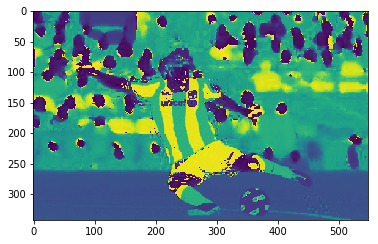

In [14]:
plt.imshow(hsi[0][:, :, 0])

[[ 32.  32.  24. ... 187. 184. 180.]
 [ 43.  25.   4. ... 161. 161. 161.]
 [ 17.   1.   1. ... 235. 230.  61.]
 ...
 [ 64.  64.  65. ...  66.  66.  67.]
 [ 64.  64.  65. ...  65.  66.  66.]
 [ 63.  64.  65. ...  64.  64.  64.]]


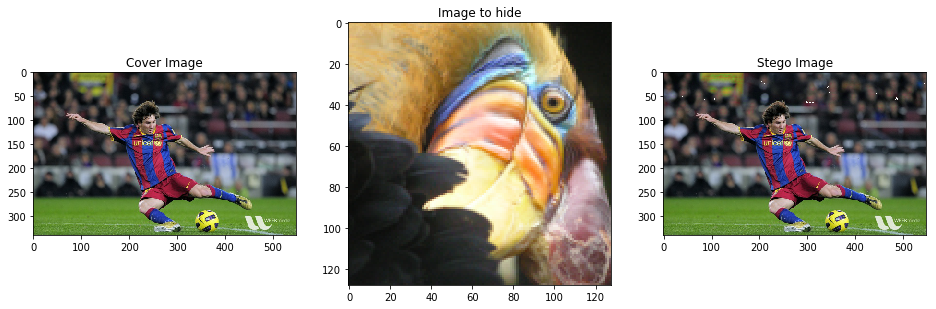

In [27]:
stego_img3 = merge(plt.imread("../data/messi5.jpg"), plt.imread("../data/bird_small.png"))

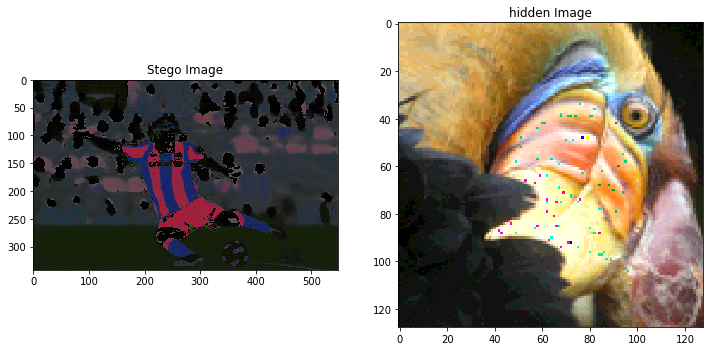

In [19]:
unmerge(stego_img3)

[[144. 144. 152. ... 181. 187. 185.]
 [150. 155. 154. ... 189. 187. 183.]
 [157. 155. 151. ... 184. 180. 186.]
 ...
 [ 65.  66.  46. ... 124.  62.  47.]
 [ 68.  69.  64. ... 121.  60.  49.]
 [ 68.  64.  60. ... 122.  59.  50.]]


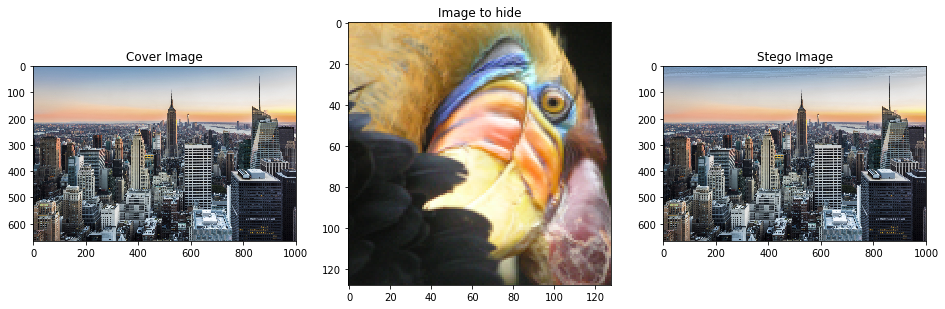

In [19]:
stego_img3 = merge(plt.imread("../data/img2.jpg"), plt.imread("../data/bird_small.png"))

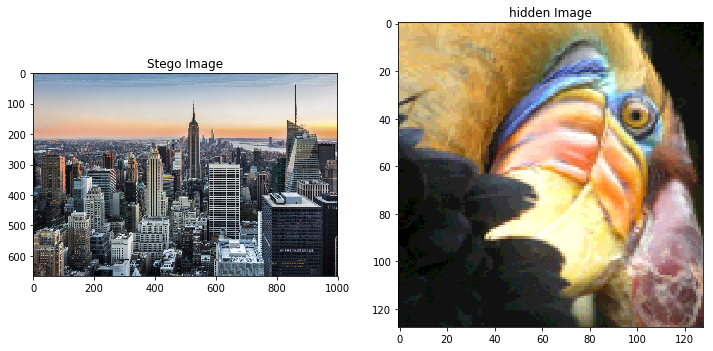

In [20]:
unmerge(stego_img3)

---

**Algorithm 2**

In [23]:
def hsi_merge(img1, img2):
    
    "convered data into string format"
    img2 = (img2*255).astype('uint8')
    str1 = ""
    str1 = "" + ("{0:016b}".format(img2.shape[0])) + ("{0:016b}".format(img2.shape[1]))
    #print(str1)
    for i in range(img2.shape[0]):
        for j in range(img2.shape[1]):
            rgb_bin_tuple = int_to_bin(tuple(img2[i][j]))
            str1  = str1 + rgb_bin_tuple[0][:4] + rgb_bin_tuple[1][:4] + rgb_bin_tuple[2][:4]
            #print(tuple(img_bird[0][0]), rgb_bin_tuple, str1)

    #print("str1 :", str1[:32],len(str1))
    
    "get hsi image of cover image"
    #hsi, I = rgb_to_hsi(img1)
    #I1 = (I*255).astype("uint8")
    I1 = img1[:, :, 2]
    
    "Change bits from I channel"
    I1bin = np.empty(I1.shape)
    str_idx = 0
    for i in range((I1.shape[0])):
        for j in range((I1.shape[1])):
            if(str_idx < len(str1)):
                #if(i==0 and j<8):
                    #print(i, j, (chnbits(I1[i,j], str1[str_idx:str_idx+4])))
                I1bin[i, j] = bin2int(chnbits(I1[i,j], str1[str_idx:str_idx+4]))
                str_idx = str_idx + 4
            else:
                I1bin[i, j] = I1[i, j]
                #I1bin[i, j] = bin2int(chnbits(I1[i,j], "0000"))
    
    #for j in range(8):
    #    print("{0:08b}".format(int(I1bin[0, j])))
    #plt.figure(figsize = (12, 9))
    #plt.subplot(121)
    #plt.imshow(I1bin)
    #plt.title("Bin changed")
    #print(I1bin)
            
    #I1bin_norm = (I1bin - I1bin.min())/(I1bin.max() - I1bin.min())
    #h, s = hsi[:, : ,0], hsi[:, : ,1]
    #hsi_ch = np.dstack((h, s, I1bin))
    new_img = np.zeros(img1.shape)
    new_img[:, :, 2] = I1bin
    new_img[:, :, 1] = img1[:, :, 1]
    new_img[:, :, 0] = img1[:, :, 0]
    
    return new_img

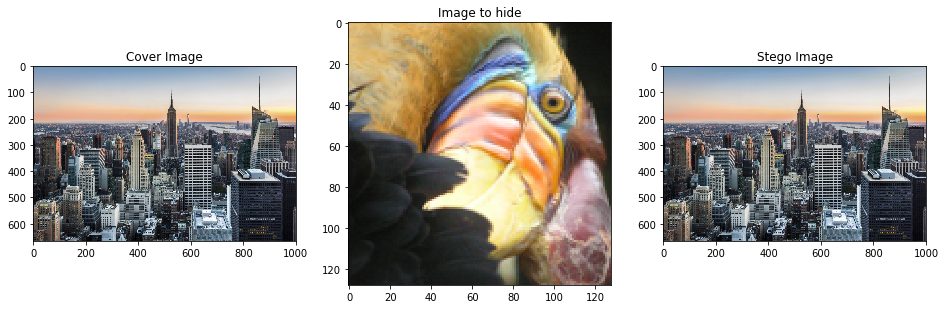

In [24]:
stego_img = merge(plt.imread("data/img2.jpg"), plt.imread("data/bird_small.png"))